<font size = 2> <B> PHILIP AUERBACH <BR>UNI: PJA2113 </B></font>

<font size = 2> <B> Predicting the next F1 Qualifier </B></font><br> <B> Lab #5 </B> <br> Description of Project: <br> The purpose of the Lab is to attmept to develop a model which can efficetively predict a Formula 1 Race, based on Praticed laps of the race. We will train a the Random Forst Model on all the pratice laps and qualification data provided by a OPENF1 spreadsheet I created in Palantir's Foundry. This includes race data from the 2023 to 2025 Formula one race. At the end I will 

In [77]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load data
complete_f1_df = pd.read_csv('F1_Class_Datasheet.csv')
complete_f1_df.head(5)


,date_lap_start,meeting_key,session_key,driver_number,lap_number,lap_duration,sector_1,sector_2,sector_3,compound,session_type,circuit_key,country_name,year,meeting_name,full_name
0,2024-11-03T10:33:18.629Z,1249,9627,81,2,93.249,23.612,49.652,19.985,WET,Qualifying,14,Brazil,2024,São Paulo Grand Prix,Oscar PIASTRI
1,2024-11-03T10:34:51.874Z,1249,9627,81,3,92.814,24.080,49.304,19.430,WET,Qualifying,14,Brazil,2024,São Paulo Grand Prix,Oscar PIASTRI
2,2024-11-03T10:36:24.710Z,1249,9627,81,4,91.999,23.130,48.737,20.132,WET,Qualifying,14,Brazil,2024,São Paulo Grand Prix,Oscar PIASTRI
3,2024-11-03T10:49:29.505Z,1249,9627,81,7,91.130,23.057,47.647,19.410,WET,Qualifying,14,Brazil,2024,São Paulo Grand Prix,Oscar PIASTRI
4,2024-11-03T10:52:37.785Z,1249,9627,81,9,114.383,23.765,70.892,19.726,WET,Qualifying,14,Brazil,2024,São Paulo Grand Prix,Oscar PIASTRI


Next I want to separate the most recent race data because this is the data I want to use see if the model works. 

<b> Splitting Data</b>

In [78]:
# Next up will split our data from our train model and the data that we will use to predict a qualify result
df_f1_train = complete_f1_df[complete_f1_df['meeting_key'] != 1264]
df_f1_1264  = complete_f1_df[complete_f1_df['meeting_key'] == 1264]

<b> Creating Fastest Laps Dataframe </b>

In [79]:
# Extract each driver’s fastest practice lap
practice_df = df_f1_train[df_f1_train['session_type'] == 'Practice']
fastest_laps = (
    practice_df
    .sort_values('lap_duration')
    .groupby(['session_key','meeting_key','driver_number','circuit_key'])
    .first()
    .reset_index()
)

agg_practice = fastest_laps[[
    'session_key','meeting_key','driver_number','circuit_key',
    'lap_duration','sector_1','sector_2','sector_3','lap_number','year'
]]
agg_practice.columns = [
    'session_key','meeting_key','driver_number','circuit_key',
    'practice_lap_best','sector1_fastest','sector2_fastest','sector3_fastest',
    'lap_number_fastest','year'
]

<B> Creating Best Qualifying Dataframe </b>

In [80]:
# Prepare target: best qualifying lap per driver per weekend
qual_best = df_f1_train[df_f1_train['session_type']=='Qualifying']
qual_target = (
    qual_best
    .groupby(['meeting_key','driver_number'])['lap_duration']
    .min()
    .reset_index()
)
qual_target.columns = ['meeting_key','driver_number','best_qual_lap']

#  Merge training and target 
train_df = pd.merge(agg_practice, qual_target, on=['meeting_key','driver_number'])

<B>Creating Training Model </B>

In [81]:
# Now dropping unwanted coloumns 
train_df = train_df.drop(columns=[
    'circuit_qual_best',   # if you still have it
    'year',
    'lap_number_fastest'
], errors='ignore')
# 7) Train/Test Split
X = train_df.drop(columns=['best_qual_lap','meeting_key','driver_number'])
y = train_df['best_qual_lap']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)



<b> OLS Regression / Mean Squared Error / R Squared </b> 

In [ ]:
# OLS Regression
ols = LinearRegression()
ols.fit(X_train, y_train)
ols_preds = ols.predict(X_test)
print("OLS MSE:", mean_squared_error(y_test, ols_preds))
print("OLS R2:", r2_score(y_test, ols_preds))



OLS MSE: 19.319544811628337
OLS R2: 0.8201094595185189


<b> Coefficients of Model </b> 

In [ ]:
# Getting Coefficients 
coefficients = pd.Series(ols.coef_, index=X.columns)
coefficients

session_key         -0.000385
circuit_key          0.019739
practice_lap_best    0.569766
sector1_fastest      0.230199
sector2_fastest      0.248488
sector3_fastest      0.091079
dtype: float64

Pratice_lap_best : For a one unit increase of best_qualify_lap is associated with a a 0.56 increase in pratice_lap_best, this is fairly significant

Session_key : For a one unit increase of best_qualify_lap is associated with a very small decrease in session_key, showing this has little to no impact on best_qualify_lap

Sector 2 : For a one unit increase of best_qualify_lap is associated with 0.248 increase in pratice_lap_best, showing this has relevant signifance on best_qualify_lap 

<b> Random Forest Model </B>

In [ ]:
# Random Forest + Grid Search
rf = RandomForestRegressor()
rf_params = {
    'n_estimators': [100,200,300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['sqrt']
}
rf_grid = GridSearchCV(rf, rf_params, cv=3, n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
rf_preds = best_rf.predict(X_test)
print("RF Mean Squared Error:", mean_squared_error(y_test, rf_preds))
print("RF R Squared:", r2_score(y_test, rf_preds))



Fitting 3 folds for each of 108 candidates, totalling 324 fits
RF MSE: 4.048832720966123
RF R2: 0.9623000068792866


In our results, we can see that R Squared has increased and the MSE has decreased. This different helps us see that the Random Forest model was capable of making more accurate predictions and explained the data better to previous models.

<b> Feature Importance </b>

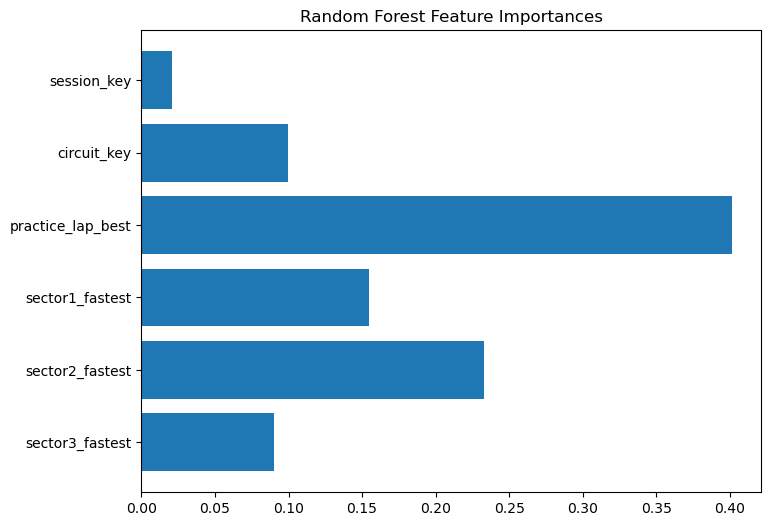

In [ ]:
# Plotting Feature Importances
importances = best_rf.feature_importances_
plt.figure(figsize=(8,6))
plt.barh(X.columns, importances)
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

Taking a look at feature importance we can see a variety of results. First off we can see that the most important feature is the best pratice lap preformance, this seems evident, the faster you drive a lap in pratice the faster you'll drive in qualify. The sector data actually provides us with intersting observations.

Sector 2: We see that this is the 2nd most important variable, this is interesting because in F1 races, Sector 2 is usually the more technicaly and complex sector of the track filled with tight and complex corners. So the best drivers in sector 2, usually shaved off alot more time than the others. 

Sector 1: We see this is the third most important variable. The first sector in F1 is usually long straits, that require flat out speed to out perform the competition. This shows us the importance of F1 teams that are able to build the fastest car on a long strait. 

Circuit Key: 4th most important varible. This represents the Race Tracks. It's importance shows use that drivers have favorite Race Tracks and are capable of driving them better than others.

<b> Attempting to Predict Qualify Lap outcomes </b>

In this section I attempted to predict the result of who would be the fastest driver for qualify for the Austria GP (Meeting_Key = 1264)

Sadly the results don't align with anythign I can interpret based on the actually results. This does show how many other factors go into F1 that are not implemented in my current model or that I haven't properly solved the model just yet. 

In [ ]:
# Predict for meeting_key 1264: extract fastest practice laps
practice_1264 = df_f1_1264[df_f1_1264['session_type']=='Practice']
fastest_1264 = (
    practice_1264
    .sort_values('lap_duration')
    .groupby(['session_key','meeting_key','driver_number','circuit_key'])
    .first()
    .reset_index()
)

agg_1264 = fastest_1264[[
    'session_key','meeting_key','driver_number','circuit_key',
    'lap_duration','sector_1','sector_2','sector_3','lap_number','year'
]]
agg_1264.columns = [
    'session_key','meeting_key','driver_number','circuit_key',
    'practice_lap_best','sector1_fastest','sector2_fastest','sector3_fastest',
    'lap_number_fastest','year'
]


# drop it
agg_1264 = agg_1264.drop(columns=[
    'circuit_qual_best',
    'year',
    'lap_number_fastest'
], errors='ignore')
X_1264 = agg_1264[X_train.columns].fillna(X_train.mean())

# Fill missing history, predict
agg_1264['predicted_qual_lap'] = best_rf.predict(X_1264)



# Merge driver names and show ranked results
name_map = df_f1_1264[['driver_number','full_name']].drop_duplicates()
agg_1264 = pd.merge(agg_1264,name_map,on='driver_number',how='left')

unique_preds = (
    agg_1264
    .groupby(['driver_number','full_name'], as_index=False)['predicted_qual_lap']
    .min()
    .sort_values('predicted_qual_lap')
    .reset_index(drop=True)
)

print(unique_preds)

    driver_number          full_name  predicted_qual_lap
0              23    Alexander ALBON           64.825302
1              63     George RUSSELL           64.825302
2               5  Gabriel BORTOLETO           64.825302
3              12     Kimi ANTONELLI           64.825302
4              14    Fernando ALONSO           64.825302
5              30        Liam LAWSON           64.825302
6              18       Lance STROLL           64.825302
7              22       Yuki TSUNODA           64.825302
8              87     Oliver BEARMAN           64.825302
9              27    Nico HULKENBERG           64.825302
10             55       Carlos SAINZ           64.864229
11             31       Esteban OCON           64.874151
12              1     Max VERSTAPPEN           64.880902
13             16    Charles LECLERC           64.880902
14             10       Pierre GASLY           64.915128
15             44     Lewis HAMILTON           64.917677
16              6       Isack H